In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson
%matplotlib inline

# matplotlib.use('Agg')

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()

In [52]:
def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

In [53]:

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0
    returns += -(MOVE_CAR_COST) * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = max(min(state[0] - action, MAX_CARS), 0)
    NUM_OF_CARS_SECOND_LOC = max(min(state[1] + action, MAX_CARS), 0)
    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)
            
            
            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)
            
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc
            
            if constant_returned_cars:
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc][num_of_cars_second_loc])
              
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        returns += prob_return * prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc][num_of_cars_second_loc])
    return returns

    

In [34]:
value= np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros(value.shape, dtype=np.int)
iterations = 0
while True:
    # Policy Evalution
    while True:
        old_value = value.copy()
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                returns = expected_return([i,j], policy[i,j], value, True)
                value[i,j] = returns
        max_value_change = abs(old_value - value).max()
        print('max value change {}'.format(max_value_change))
        if max_value_change < 1e-4:
            break
    
    
    # policy improvement
    policy_stable = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                if -j <= action <= i:
                    action_returns.append(expected_return([i,j], action, value, True))
                else:
                    action_returns.append(-np.inf)
            new_action = actions[np.argmax(action_returns)]
            policy[i,j] = new_action
            if policy_stable and new_action != old_action:
                policy_stable = False
    if policy_stable:
        break
    iterations += 1

/tmp/ipykernel_14060/1302048496.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros(value.shape, dtype=np.int)


max value change 196.62783361783852
max value change 134.98823859766583
max value change 91.41415360228919
max value change 67.17097732555729
max value change 51.29055484635097
max value change 38.49091000659837
max value change 29.406139835126424
max value change 25.7210573245398
max value change 22.381602293031023
max value change 19.40385808254939
max value change 16.77577350573091
max value change 14.47251552455765
max value change 12.464101852186843
max value change 10.719367983418692
max value change 9.20806226246873
max value change 7.9019189666795455
max value change 6.775146571130392
max value change 5.8045764710083745
max value change 4.969618520007145
max value change 4.252112693842776
max value change 3.6361309524054946
max value change 3.107761240497666
max value change 2.654891834022692
max value change 2.26700589940549
max value change 1.9349911763441128
max value change 1.650966802154585
max value change 1.4081276418079938
max value change 1.2006055672075036
max value c

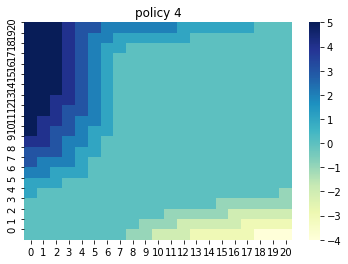

In [76]:
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu")
# fig.set_ylabel('# cars at first location')
# fig.invert_yaxis()
# fig.set_xlabel('# cars at second location')
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_yticklabels(list((range(MAX_CARS + 1))))
fig.set_title('policy {}'.format(iterations))
plt.show()